In [19]:
import pm4py

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.metrics import r2_score

In [2]:
dataframe_2012 = pd.read_csv('clean_BPI_2012.csv')

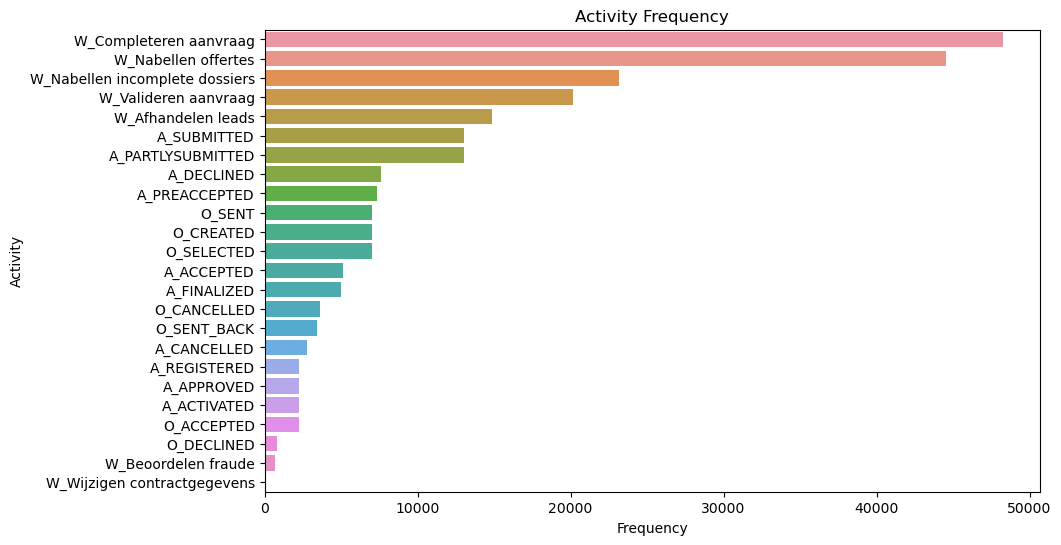

In [3]:
# Assuming 'concept:name' column contains the activity names
activity_counts = dataframe_2012['concept:name'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=activity_counts.values, y=activity_counts.index)
plt.xlabel('Frequency')
plt.ylabel('Activity')
plt.title('Activity Frequency')
plt.show()

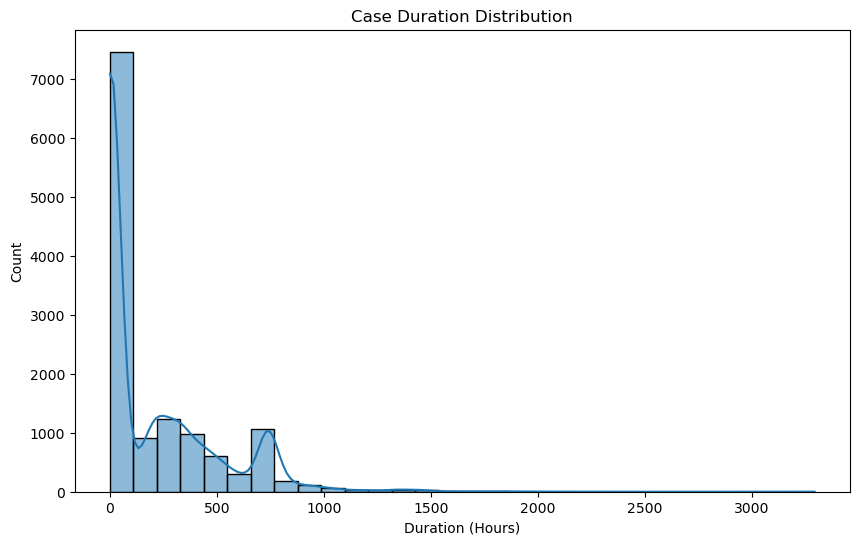

In [4]:
# Assuming 'time:timestamp' is the timestamp and 'case:concept:name' is the case ID
dataframe_2012['time:timestamp'] = pd.to_datetime(dataframe_2012['time:timestamp'])
case_durations = dataframe_2012.groupby('case:concept:name')['time:timestamp'].agg([min, max])
case_durations['duration'] = (case_durations['max'] - case_durations['min']).dt.total_seconds() / 3600  # Duration in hours

plt.figure(figsize=(10, 6))
sns.histplot(case_durations['duration'], bins=30, kde=True)
plt.xlabel('Duration (Hours)')
plt.ylabel('Count')
plt.title('Case Duration Distribution')
plt.show()


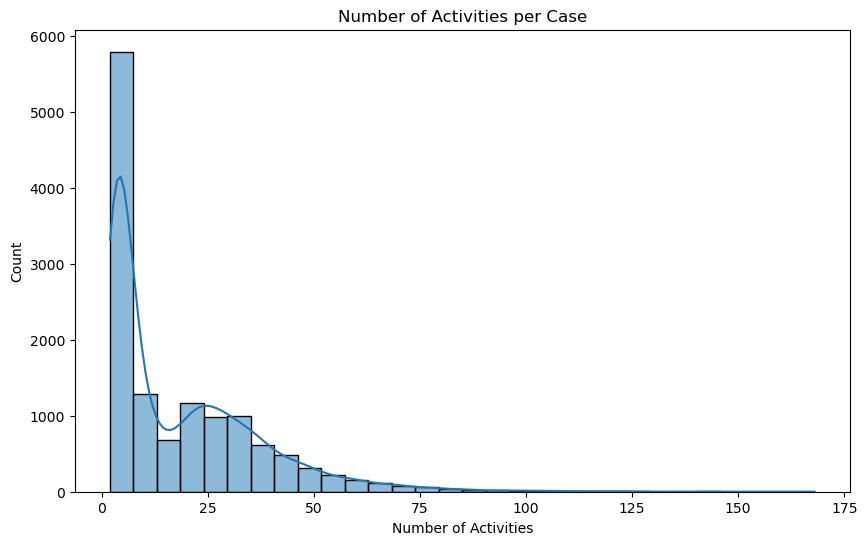

In [5]:
activities_per_case = dataframe_2012.groupby('case:concept:name').size()

plt.figure(figsize=(10, 6))
sns.histplot(activities_per_case, bins=30, kde=True)
plt.xlabel('Number of Activities')
plt.ylabel('Count')
plt.title('Number of Activities per Case')
plt.show()


In [6]:
dataframe_2012

,Unnamed: 0,org:resource,lifecycle:transition,concept:name,time:timestamp,case:REG_DATE,case:concept:name,case:AMOUNT_REQ,timestamp_difference
0,0,112,COMPLETE,A_SUBMITTED,2011-10-01 00:38:44.546,01:10:2011 00:38:44.546000,173688,20000,NaN
1,1,112,COMPLETE,A_PARTLYSUBMITTED,2011-10-01 00:38:44.880,01:10:2011 00:38:44.546000,173688,20000,0 days 00:00:00.334000
2,2,112,COMPLETE,A_PREACCEPTED,2011-10-01 00:39:37.906,01:10:2011 00:38:44.546000,173688,20000,0 days 00:00:53.026000
3,3,112,SCHEDULE,W_Completeren aanvraag,2011-10-01 00:39:38.875,01:10:2011 00:38:44.546000,173688,20000,0 days 00:00:00.969000
4,26,112,COMPLETE,A_SUBMITTED,2011-10-01 08:08:58.256,01:10:2011 08:08:58.256000,173691,5000,0 days 07:29:19.381000
...,...,...,...,...,...,...,...,...,...
243482,231114,11339,COMPLETE,A_APPROVED,2012-03-14 15:31:28.859,13:02:2012 15:50:41.425000,208901,11000,0 days 00:19:08.004000
243483,231115,11339,COMPLETE,A_ACTIVATED,2012-03-14 15:31:28.859,13:02:2012 15:50:41.425000,208901,11000,0 days 00:00:00
243484,231116,11339,COMPLETE,O_ACCEPTED,2012-03-14 15:31:28.859,13:02:2012 15:50:41.425000,208901,11000,0 days 00:00:00
243485,231117,11339,COMPLETE,A_REGISTERED,2012-03-14 15:31:28.859,13:02:2012 15:50:41.425000,208901,11000,0 days 00:00:00


In [7]:
dataframe_2012['concept:name'].value_counts()

concept:name
W_Completeren aanvraag            48240
W_Nabellen offertes               44543
W_Nabellen incomplete dossiers    23144
W_Valideren aanvraag              20148
W_Afhandelen leads                14882
A_SUBMITTED                       13065
A_PARTLYSUBMITTED                 13058
A_DECLINED                         7617
A_PREACCEPTED                      7349
O_SENT                             7011
O_CREATED                          7011
O_SELECTED                         7011
A_ACCEPTED                         5100
A_FINALIZED                        5000
O_CANCELLED                        3642
O_SENT_BACK                        3445
A_CANCELLED                        2796
A_REGISTERED                       2239
A_APPROVED                         2238
A_ACTIVATED                        2238
O_ACCEPTED                         2237
O_DECLINED                          802
W_Beoordelen fraude                 660
W_Wijzigen contractgegevens          11
Name: count, dtype: int64

Text(0, 0.5, 'Frequency')

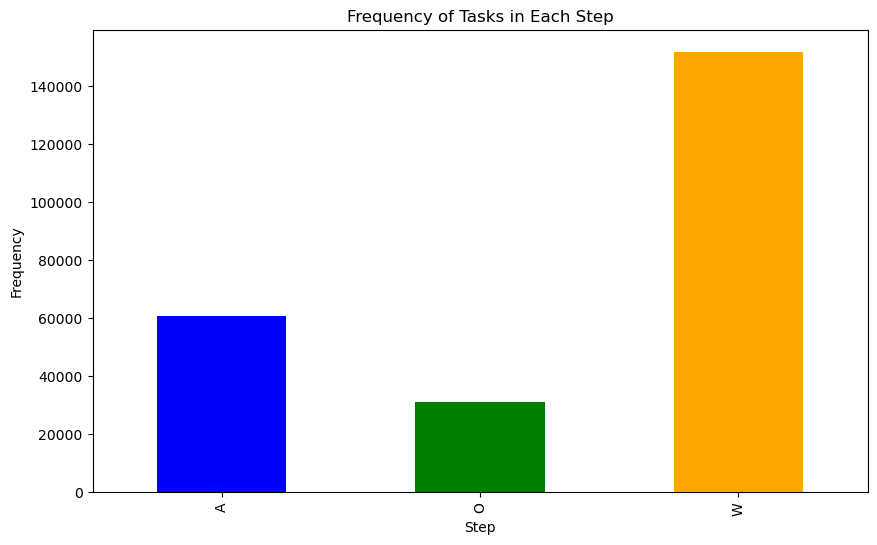

In [8]:
# Extract prefixes ('W_', 'O_', 'A_')
dataframe_2012['prefix'] = dataframe_2012['concept:name'].str.split('_').str[0]

# Create separate columns for each step
dataframe_2012['W'] = dataframe_2012['prefix'].apply(lambda x: x == 'W')
dataframe_2012['O'] = dataframe_2012['prefix'].apply(lambda x: x == 'O')
dataframe_2012['A'] = dataframe_2012['prefix'].apply(lambda x: x == 'A')

# Plot the frequency of tasks chosen at each step
fig, ax = plt.subplots(figsize=(10, 6))

dataframe_2012.groupby('prefix').size().plot(kind='bar', color=['blue', 'green', 'orange'], ax=ax)
ax.set_title('Frequency of Tasks in Each Step')
ax.set_xlabel('Step')
ax.set_ylabel('Frequency')

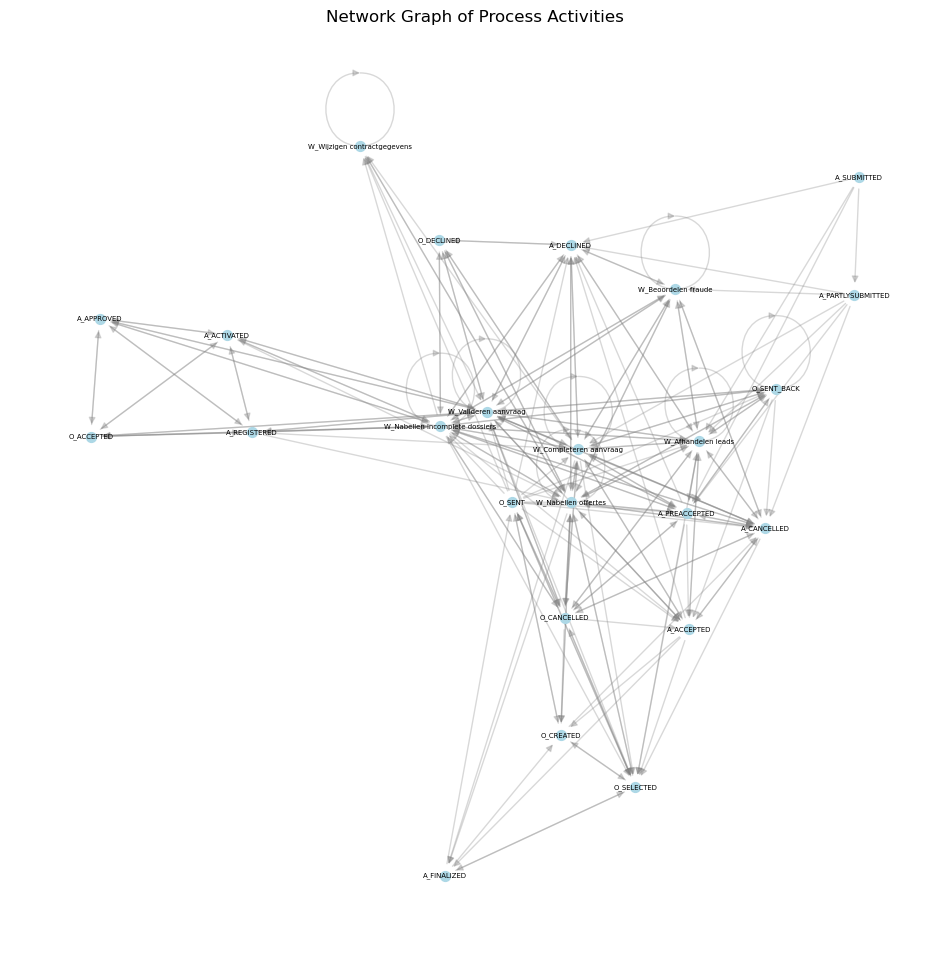

In [9]:
# Create a directed graph
G = nx.DiGraph()

# Add edges for transitions between activities for each case
# Here, we'll track the last activity to create a sequence within each case
last_activity = {}

for index, row in dataframe_2012.iterrows():
    case_id = row['case:concept:name']
    activity = row['concept:name']
    
    # Check if the current case had a previous activity
    if case_id in last_activity:
        # Add edge from last activity to current activity for the same case
        G.add_edge(last_activity[case_id], activity)
    
    # Update the last activity for the current case
    last_activity[case_id] = activity

# Use a spring layout to visualize the graph, attempting to reflect some hierarchy or sequence
pos = nx.spring_layout(G, seed=42)  # Seed for reproducible layout

# Drawing the graph
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_size=50, node_color="lightblue")
nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color="gray")
nx.draw_networkx_labels(G, pos, font_size=5, font_family="sans-serif")

plt.title("Network Graph of Process Activities")
plt.axis("off")  # Turn off the axis
plt.show()

In [10]:
dataframe_2012['time:timestamp'] = pd.to_datetime(dataframe_2012['time:timestamp'])

# Generate event sequence numbers within each case
dataframe_2012['event_seq'] = dataframe_2012.groupby('case:concept:name').cumcount() + 1

dataframe_2012

,Unnamed: 0,org:resource,lifecycle:transition,concept:name,time:timestamp,case:REG_DATE,case:concept:name,case:AMOUNT_REQ,timestamp_difference,prefix,W,O,A,event_seq
0,0,112,COMPLETE,A_SUBMITTED,2011-10-01 00:38:44.546,01:10:2011 00:38:44.546000,173688,20000,NaN,A,False,False,True,1
1,1,112,COMPLETE,A_PARTLYSUBMITTED,2011-10-01 00:38:44.880,01:10:2011 00:38:44.546000,173688,20000,0 days 00:00:00.334000,A,False,False,True,2
2,2,112,COMPLETE,A_PREACCEPTED,2011-10-01 00:39:37.906,01:10:2011 00:38:44.546000,173688,20000,0 days 00:00:53.026000,A,False,False,True,3
3,3,112,SCHEDULE,W_Completeren aanvraag,2011-10-01 00:39:38.875,01:10:2011 00:38:44.546000,173688,20000,0 days 00:00:00.969000,W,True,False,False,4
4,26,112,COMPLETE,A_SUBMITTED,2011-10-01 08:08:58.256,01:10:2011 08:08:58.256000,173691,5000,0 days 07:29:19.381000,A,False,False,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243482,231114,11339,COMPLETE,A_APPROVED,2012-03-14 15:31:28.859,13:02:2012 15:50:41.425000,208901,11000,0 days 00:19:08.004000,A,False,False,True,26
243483,231115,11339,COMPLETE,A_ACTIVATED,2012-03-14 15:31:28.859,13:02:2012 15:50:41.425000,208901,11000,0 days 00:00:00,A,False,False,True,27
243484,231116,11339,COMPLETE,O_ACCEPTED,2012-03-14 15:31:28.859,13:02:2012 15:50:41.425000,208901,11000,0 days 00:00:00,O,False,True,False,28
243485,231117,11339,COMPLETE,A_REGISTERED,2012-03-14 15:31:28.859,13:02:2012 15:50:41.425000,208901,11000,0 days 00:00:00,A,False,False,True,29


In [11]:
dataframe_2012 = dataframe_2012.drop(columns=['index', 'Unnamed: 0', 'level_0'])

KeyError: "['index', 'level_0'] not found in axis"

In [12]:
# Split the DataFrame into training and test sets
train_percentage = 0.8

split_index = int(len(dataframe_2012) * train_percentage)

train_set = dataframe_2012[:split_index]
test_set = dataframe_2012[split_index:]

In [13]:
dataframe_2012

,Unnamed: 0,org:resource,lifecycle:transition,concept:name,time:timestamp,case:REG_DATE,case:concept:name,case:AMOUNT_REQ,timestamp_difference,prefix,W,O,A,event_seq
0,0,112,COMPLETE,A_SUBMITTED,2011-10-01 00:38:44.546,01:10:2011 00:38:44.546000,173688,20000,NaN,A,False,False,True,1
1,1,112,COMPLETE,A_PARTLYSUBMITTED,2011-10-01 00:38:44.880,01:10:2011 00:38:44.546000,173688,20000,0 days 00:00:00.334000,A,False,False,True,2
2,2,112,COMPLETE,A_PREACCEPTED,2011-10-01 00:39:37.906,01:10:2011 00:38:44.546000,173688,20000,0 days 00:00:53.026000,A,False,False,True,3
3,3,112,SCHEDULE,W_Completeren aanvraag,2011-10-01 00:39:38.875,01:10:2011 00:38:44.546000,173688,20000,0 days 00:00:00.969000,W,True,False,False,4
4,26,112,COMPLETE,A_SUBMITTED,2011-10-01 08:08:58.256,01:10:2011 08:08:58.256000,173691,5000,0 days 07:29:19.381000,A,False,False,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243482,231114,11339,COMPLETE,A_APPROVED,2012-03-14 15:31:28.859,13:02:2012 15:50:41.425000,208901,11000,0 days 00:19:08.004000,A,False,False,True,26
243483,231115,11339,COMPLETE,A_ACTIVATED,2012-03-14 15:31:28.859,13:02:2012 15:50:41.425000,208901,11000,0 days 00:00:00,A,False,False,True,27
243484,231116,11339,COMPLETE,O_ACCEPTED,2012-03-14 15:31:28.859,13:02:2012 15:50:41.425000,208901,11000,0 days 00:00:00,O,False,True,False,28
243485,231117,11339,COMPLETE,A_REGISTERED,2012-03-14 15:31:28.859,13:02:2012 15:50:41.425000,208901,11000,0 days 00:00:00,A,False,False,True,29


In [14]:
# Calculate the difference between the current event's timestamp and the next one
dataframe_2012['time_to_next_event'] = dataframe_2012.groupby('case:concept:name')['time:timestamp'].transform(lambda x: x.diff().shift(-1))

# Convert the 'time_to_next_event' from timedelta to seconds (or any other numeric representation you prefer)
dataframe_2012['time_to_next_event_seconds'] = dataframe_2012['time_to_next_event'].dt.total_seconds().fillna(0)

# Step 2: Compute the mean duration for each 'concept:name'
average_durations_per_concept = dataframe_2012[['time_to_next_event_seconds', 'concept:name']].groupby('concept:name').median().rename(columns={'time_to_next_event_seconds': 'mean_duration_seconds'})

# Step 3: Merge this mean duration back into the original dataframe to use as a prediction
dataframe_2012 = pd.merge(dataframe_2012, average_durations_per_concept, how='left', on='concept:name')

# Rename the 'mean_duration_seconds' column to something like 'predicted_duration_seconds'
dataframe_2012.rename(columns={'mean_duration_seconds': 'predicted_time_to_next_event_seconds'}, inplace=True)

dataframe_2012[['predicted_time_to_next_event_seconds', 'time_to_next_event_seconds']] = dataframe_2012[['predicted_time_to_next_event_seconds', 'time_to_next_event_seconds']].round(2)

# Optionally, convert the 'predicted_time_to_next_event_seconds' back to a timedelta for readability or further datetime operations
# dataframe_2012['predicted_time_to_next_event'] = pd.to_timedelta(dataframe_2012['predicted_time_to_next_event_seconds'], unit='s')

dataframe_2012

,Unnamed: 0,org:resource,lifecycle:transition,concept:name,time:timestamp,case:REG_DATE,case:concept:name,case:AMOUNT_REQ,timestamp_difference,prefix,W,O,A,event_seq,time_to_next_event,time_to_next_event_seconds,predicted_time_to_next_event_seconds
0,0,112,COMPLETE,A_SUBMITTED,2011-10-01 00:38:44.546,01:10:2011 00:38:44.546000,173688,20000,NaN,A,False,False,True,1,0 days 00:00:00.334000,0.33,0.27
1,1,112,COMPLETE,A_PARTLYSUBMITTED,2011-10-01 00:38:44.880,01:10:2011 00:38:44.546000,173688,20000,0 days 00:00:00.334000,A,False,False,True,2,0 days 00:00:53.026000,53.03,37.00
2,2,112,COMPLETE,A_PREACCEPTED,2011-10-01 00:39:37.906,01:10:2011 00:38:44.546000,173688,20000,0 days 00:00:53.026000,A,False,False,True,3,0 days 00:00:00.969000,0.97,0.39
3,3,112,SCHEDULE,W_Completeren aanvraag,2011-10-01 00:39:38.875,01:10:2011 00:38:44.546000,173688,20000,0 days 00:00:00.969000,W,True,False,False,4,12 days 09:25:48.050000,1070748.05,177.27
4,26,112,COMPLETE,A_SUBMITTED,2011-10-01 08:08:58.256,01:10:2011 08:08:58.256000,173691,5000,0 days 07:29:19.381000,A,False,False,True,1,0 days 00:00:03.939000,3.94,0.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243482,231114,11339,COMPLETE,A_APPROVED,2012-03-14 15:31:28.859,13:02:2012 15:50:41.425000,208901,11000,0 days 00:19:08.004000,A,False,False,True,26,0 days 00:00:00,0.00,0.00
243483,231115,11339,COMPLETE,A_ACTIVATED,2012-03-14 15:31:28.859,13:02:2012 15:50:41.425000,208901,11000,0 days 00:00:00,A,False,False,True,27,0 days 00:00:00,0.00,0.00
243484,231116,11339,COMPLETE,O_ACCEPTED,2012-03-14 15:31:28.859,13:02:2012 15:50:41.425000,208901,11000,0 days 00:00:00,O,False,True,False,28,0 days 00:00:00,0.00,0.00
243485,231117,11339,COMPLETE,A_REGISTERED,2012-03-14 15:31:28.859,13:02:2012 15:50:41.425000,208901,11000,0 days 00:00:00,A,False,False,True,29,0 days 00:00:05.825000,5.82,0.00


In [24]:
dataframe_2012['column_similarity_percentage'] = (dataframe_2012['time_to_next_event_seconds'] == dataframe_2012['predicted_time_to_next_event_seconds']).mean() * 100

accuracy = dataframe_2012['column_similarity_percentage'].loc[0]

In [16]:
accuracy

8.472731603740652

In [22]:
r2 = r2_score(dataframe_2012['time_to_next_event_seconds'], dataframe_2012['predicted_time_to_next_event_seconds'])
print(r2)

-0.0016393890937371758


In [23]:

dataframe_2012 = dataframe_2012.drop(columns=['column_similarity_percentage'])


KeyError: "['column_similarity_percentage'] not found in axis"

In [18]:
# Subtract the timestamp of the first event in each case from all events in that case
dataframe_2012['elapsed_time_from_start'] = dataframe_2012.groupby('case:concept:name')['time:timestamp'].transform(lambda x: x - x.min())

# Calculate the average elapsed time from the start for each 'event_seq'
predicted_start_time = dataframe_2012.groupby('event_seq')['elapsed_time_from_start'].mean().reset_index(name='predicted_start_time')

# Merge this average elapsed time back into the original DataFrame to use as a predicted start time
dataframe_2012 = pd.merge(dataframe_2012, predicted_start_time, on='event_seq', how='left')

In [25]:
dataframe_2012

,Unnamed: 0,org:resource,lifecycle:transition,concept:name,time:timestamp,case:REG_DATE,case:concept:name,case:AMOUNT_REQ,timestamp_difference,prefix,W,O,A,event_seq,time_to_next_event,time_to_next_event_seconds,predicted_time_to_next_event_seconds,elapsed_time_from_start,predicted_start_time,column_similarity_percentage
0,0,112,COMPLETE,A_SUBMITTED,2011-10-01 00:38:44.546,01:10:2011 00:38:44.546000,173688,20000,NaN,A,False,False,True,1,0 days 00:00:00.334000,0.33,0.27,0 days 00:00:00,0 days 00:00:00,8.472732
1,1,112,COMPLETE,A_PARTLYSUBMITTED,2011-10-01 00:38:44.880,01:10:2011 00:38:44.546000,173688,20000,0 days 00:00:00.334000,A,False,False,True,2,0 days 00:00:53.026000,53.03,37.00,0 days 00:00:00.334000,0 days 00:00:00.614308692,8.472732
2,2,112,COMPLETE,A_PREACCEPTED,2011-10-01 00:39:37.906,01:10:2011 00:38:44.546000,173688,20000,0 days 00:00:53.026000,A,False,False,True,3,0 days 00:00:00.969000,0.97,0.39,0 days 00:00:53.360000,0 days 00:05:03.579043484,8.472732
3,3,112,SCHEDULE,W_Completeren aanvraag,2011-10-01 00:39:38.875,01:10:2011 00:38:44.546000,173688,20000,0 days 00:00:00.969000,W,True,False,False,4,12 days 09:25:48.050000,1070748.05,177.27,0 days 00:00:54.329000,2 days 18:32:51.301924592,8.472732
4,26,112,COMPLETE,A_SUBMITTED,2011-10-01 08:08:58.256,01:10:2011 08:08:58.256000,173691,5000,0 days 07:29:19.381000,A,False,False,True,1,0 days 00:00:03.939000,3.94,0.27,0 days 00:00:00,0 days 00:00:00,8.472732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243482,231114,11339,COMPLETE,A_APPROVED,2012-03-14 15:31:28.859,13:02:2012 15:50:41.425000,208901,11000,0 days 00:19:08.004000,A,False,False,True,26,0 days 00:00:00,0.00,0.00,29 days 23:40:47.434000,8 days 02:04:38.975233913,8.472732
243483,231115,11339,COMPLETE,A_ACTIVATED,2012-03-14 15:31:28.859,13:02:2012 15:50:41.425000,208901,11000,0 days 00:00:00,A,False,False,True,27,0 days 00:00:00,0.00,0.00,29 days 23:40:47.434000,8 days 06:29:01.375364538,8.472732
243484,231116,11339,COMPLETE,O_ACCEPTED,2012-03-14 15:31:28.859,13:02:2012 15:50:41.425000,208901,11000,0 days 00:00:00,O,False,True,False,28,0 days 00:00:00,0.00,0.00,29 days 23:40:47.434000,8 days 12:45:01.514128276,8.472732
243485,231117,11339,COMPLETE,A_REGISTERED,2012-03-14 15:31:28.859,13:02:2012 15:50:41.425000,208901,11000,0 days 00:00:00,A,False,False,True,29,0 days 00:00:05.825000,5.82,0.00,29 days 23:40:47.434000,8 days 19:16:31.725984079,8.472732


In [20]:
# Step 1: Shift the 'concept:name' within each group to get the next step
# dataframe_2012['next_step'] = dataframe_2012.groupby('case:concept:name')['concept:name'].shift(-1)

# Step 2: For each 'concept:name', calculate the most common next step
# We'll group by 'concept:name' and then use value_counts on 'next_step' to find the most common follow-up step
#most_common_next_steps = dataframe_2012.groupby('concept:name')['next_step'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index(n

# Merge the most common next step back into the original DataFrame
#dataframe_2012 = pd.merge(dataframe_2012, most_common_next_steps, how='left', on='concept:name')

# Rename the merged column to 'predicted_next_step'
#dataframe_2012.rename(columns={'most_common_next_step': 'predicted_next_step'}, inplace=True)

In [26]:
# Calculate the most common concept:name for each event_seq
most_common_concepts_by_seq = dataframe_2012.groupby('event_seq')['concept:name'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index(name='predicted_step')
# Merge the most common concept:name for each event_seq back into the original DataFrame
dataframe_2012 = pd.merge(dataframe_2012, most_common_concepts_by_seq, on='event_seq', how='left')

In [27]:
dataframe_2012.to_csv("BPI_2012_naive.csv")

In [28]:
dataframe_2012['column_similarity_percentage'] = (dataframe_2012['concept:name'] == dataframe_2012['predicted_step']).mean() * 100

accuracy = dataframe_2012['column_similarity_percentage'].loc[0]

In [29]:
accuracy

37.88374738692415